# Homework 05

### Atahan Tap
### 69374

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def safelog2(x):
    if x == 0:
        return 0
    else:
        return np.log2(x)

## Importing Data

In [3]:
training_data_set = np.genfromtxt("hw05_data_set_train.csv", delimiter = ',')
test_data_set = np.genfromtxt("hw05_data_set_test.csv", delimiter = ',')

X_training = training_data_set[:, 0]
y_training = training_data_set[:, 1]
N_training = X_training.shape[0]

X_test = test_data_set[:, 0]
y_test = test_data_set[:, 1]
N_test = X_test.shape[0]

## Decision Tree Regression

In [4]:
def decision_tree_regression(P):
    
    #Initialization
    
    node_indices = {}
    is_terminal = {}
    need_split = {}

    node_means = {}
    node_splits = {}
    node_frequencies = {}

    node_indices[1] = np.array(range(N_training))
    is_terminal[1] = False
    need_split[1] = True
    
    #Tree Inference
    
    while True:
        split_nodes = [key for key, value in need_split.items()
                          if value == True]
        
        if len(split_nodes) == 0:
            break
            
        for split_node in split_nodes:
            data_indices = node_indices[split_node]
            need_split[split_node] = False
            
            node_mean = np.mean(y_training[data_indices])

            #Prepruning
            if X_training[data_indices].size <= P:
                is_terminal[split_node] = True
                node_means[split_node] = node_mean
            else:
                is_terminal[split_node] = False
                
                unique_values = np.sort(np.unique(X_training[data_indices]))
                split_positions = (unique_values[1:len(unique_values)] + \
                                   unique_values[0:(len(unique_values) - 1)]) / 2
                split_scores = np.repeat(0.0, len(split_positions))
                
                for s in range(len(split_positions)):
                    left_indices = data_indices[X_training[data_indices] < split_positions[s]]
                    right_indices = data_indices[X_training[data_indices] >= split_positions[s]]
                    
                    total_error = 0
                    if len(left_indices) > 0:
                        total_error += np.sum((y_training[left_indices] - \
                                             np.mean(y_training[left_indices])) ** 2)
                    if len(right_indices) > 0:
                        total_error += np.sum((y_training[right_indices] - \
                                             np.mean(y_training[right_indices])) ** 2)
                    
                    split_scores[s] = total_error / (len(left_indices) + len(right_indices))
                  
                #there are only points with the same value left (or only one)
                if len(unique_values) == 1:
                    is_terminal[split_node] = True
                    node_means[split_node] = node_mean
                    continue
                
                best_split = split_positions[np.argmin(split_scores)]
                node_splits[split_node] = best_split
                
                # create left node using the selected split
                left_indices = data_indices[(X_training[data_indices] < 
                                             best_split)]
                node_indices[2 * split_node] = left_indices
                is_terminal[2 * split_node] = False
                need_split[2 * split_node] = True

                # create right node using the selected split
                right_indices = data_indices[(X_training[data_indices] >= best_split)]
                node_indices[2 * split_node + 1] = right_indices
                is_terminal[2 * split_node + 1] = False
                need_split[2 * split_node + 1] = True
                
    return node_splits, node_means, is_terminal

## Performance


In [15]:
def performance(X_values, node_splits, node_means, is_terminal):

    y_predicted = []
    
    for i in range(len(X_values)):
        index = 1
        while True:
            if is_terminal[index] == True:
                y_predicted.append(node_means[index])
                break
            else:
                #right child
                if X_values[i] > node_splits[index]:
                    index = index * 2 + 1
                #left child
                else:
                    index = index * 2
    
    return y_predicted

## Plotting

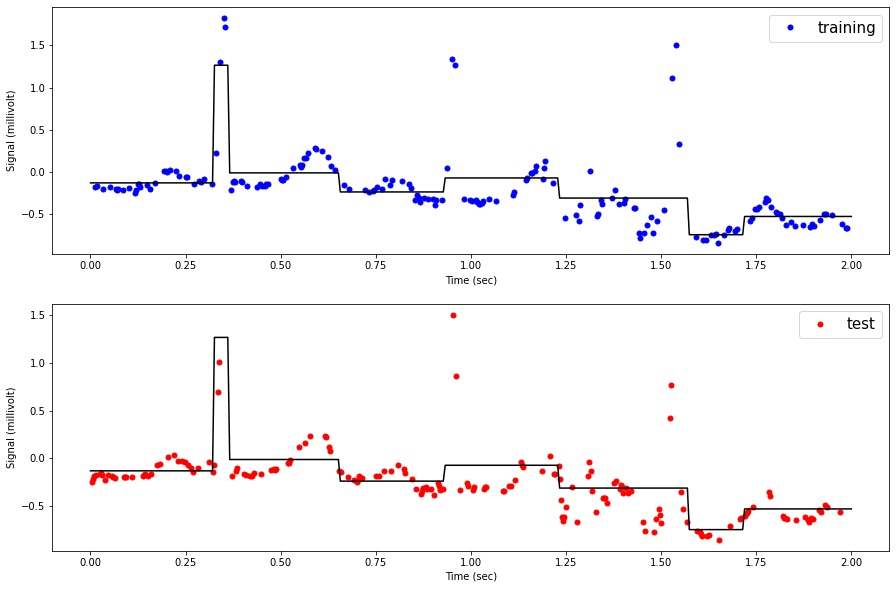

In [53]:
min_val = 0.0
max_val = 2.0
data_interval = np.linspace(min_val, max_val, 400)

#Prepruning parameter
P = 30

fig, ax = plt.subplots(2, 1, figsize = (15, 10)) 

#Training set
plt.subplot(2, 1, 1)
node_splits, node_means, is_terminal = decision_tree_regression(P)
pred_training = np.array(performance(X_training, node_splits, node_means, is_terminal))
training_plot = np.array(performance(data_interval, node_splits, node_means, is_terminal))

plt.plot(X_training, y_training, "b.", markersize = 10, label = "training")
plt.plot(data_interval, training_plot, color = "black")
plt.xlabel("Time (sec)")
plt.ylabel("Signal (millivolt)")  
plt.legend(prop={'size': 15})

#Test set
plt.subplot(2, 1, 2)
node_splits, node_means, is_terminal = decision_tree_regression(P)
pred_test = np.array(performance(X_test, node_splits, node_means, is_terminal))
test_plot = performance(data_interval, node_splits, node_means, is_terminal)

plt.plot(X_test, y_test, "r.", markersize = 10, label = "test")
plt.plot(data_interval, test_plot, color = "black")
plt.xlabel("Time (sec)")
plt.ylabel("Signal (millivolt)")  
plt.legend(prop = {'size': 15})

plt.show()

## RMSE


In [54]:
def RMSE(y, prediction):
    return np.sqrt(sum((y - prediction) ** 2) / len(y))

print("RMSE on training set is {}, when P is {}".format(RMSE(y_training, pred_training), P))
print("RMSE on test set is {}, when P is {}".format(RMSE(y_test, pred_test), P))


RMSE on training set is 0.28819293428018844, when P is 30
RMSE on test set is 0.22542236010134892, when P is 30


## Plotting with different P values

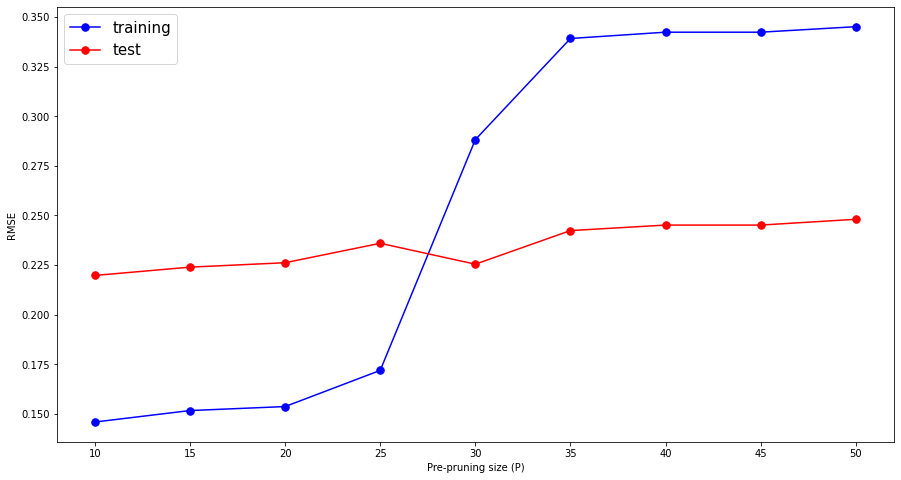

In [65]:
fig = plt.figure(figsize = (15, 8))

#Traning set
RMSEs = []

for P in range(10, 55, 5):
    node_splits, node_means, is_terminal = decision_tree_regression(P)
    pred_training = np.array(performance(X_training, node_splits, node_means, is_terminal))
    RMSEs.append(RMSE(y_training, pred_training))

RMSEs = np.array(RMSEs)
plt.plot(range(10, 55, 5), RMSEs, "b.-", markersize = 15, label = "training")

#Test set
RMSEs = []

for P in range(10, 55, 5):
    node_splits, node_means, is_terminal = decision_tree_regression(P)
    pred_test = np.array(performance(X_test, node_splits, node_means, is_terminal))
    RMSEs.append(RMSE(y_test, pred_test))

RMSEs = np.array(RMSEs)
plt.plot(range(10, 55, 5), RMSEs, "r.-", markersize = 15, label = "test")

plt.legend(prop = {'size': 15})
plt.xlabel("Pre-pruning size (P)")
plt.ylabel("RMSE")
plt.show()